In [1]:
"*ein: http://127.0.0.1:8899/make_figs.ipynb*"
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*<2>"))

SyntaxError: invalid syntax (<ipython-input-1-63a19210c978>, line 2)

In [1]:
%pylab inline
import os,sys
import pickle
from importlib import reload
#sys.path.append(os.environ["CFDGITPY"])
#sys.path.append(os.environ["CRICKFISHER"] + "/code")
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft

Populating the interactive namespace from numpy and matplotlib


In [2]:
PLOT = True # Whether to actually make the plots

In [68]:
import boulder;                         reload(boulder)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
FisherPlumes = fp.FisherPlumes

INFO:boulder:
Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


In [71]:
force_reload = False
if force_reload or ('Fbw' not in locals()):
    pairs_mode = "unsigned"
    Fbw = FisherPlumes("boulder16", which_coords = [(0.45, 0.5)], py_mode = "relative", suffix = 'wideDomain.old',pairs_mode = pairs_mode,
                       n_bootstraps = 6, random_seed = 0)
else:
    Fbw = FisherPlumes(Fbw)
    
data = {
    #"bb":Fbb,
    "bw":Fbw,
    #"bw1":Fbw1,
#    "w2":Fw2,
}

           fisher_plumes 2022/10/10 16:15:39     INFO: sim_name=<fisher_plumes.FisherPlumes object at 0x7fa4a8822cd0> was not a string, assuming it's a FisherPlumes object.


           fisher_plumes 2022/10/10 16:15:39     INFO: Attempting to copy data fields.


           fisher_plumes 2022/10/10 16:15:39     INFO: Copied data fields from FisherPlumes object.


# Compute all the statistics

In [72]:
wnd_sec = 1.
dmax    = 40000
Fbw.n_bootstraps = 50
wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
[(print(k, end = ""), sys.stdout.flush(), F.compute_all_for_window(wnd = wnd[k],
                                                                   istart = istart[k],
                                                                   window = 'boxcar',
                                                                   tukey_param = 0,
                                                                   dmax = dmax if k != "bw" else 2*dmax,
                                                                   fit_amps = False,                                                                  
)) for k, F in data.items()];

bw

           fisher_plumes 2022/10/10 16:15:40     INFO: Window set to self.wnd=50.


           fisher_plumes 2022/10/10 16:15:40     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/10 16:15:40     INFO: Computing amplitude of generalized gaussian fits to λ(s).


           fisher_plumes 2022/10/10 16:15:40     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/10 16:15:41     INFO: Computing lambdas.


           fisher_plumes 2022/10/10 16:15:41     INFO: Creating pooling functions.


           fisher_plumes 2022/10/10 16:15:42     INFO: Computing p-values.


           fisher_plumes 2022/10/10 16:15:42     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/10 16:15:43     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/10 16:15:43     INFO: Using 6 distances <= 80000


           fisher_plumes 2022/10/10 16:15:43     INFO: Computed λ for 26 frequencies and 6 distances and 51 bootstraps.


           fisher_plumes 2022/10/10 16:15:43     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/10 16:15:45    DEBUG: self.fit_params.shape=(51, 26, 2).


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:160: RuntimeWarning: divide by zero encountered in power
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:160: RuntimeWarning: divide by zero encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:160: RuntimeWarning: invalid value encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)


# Figure showing an example plume and correlations

In [22]:
save_fields = False
if save_fields:
    t = 40
    for F, name in zip([Fbw], ["wide"]):
        print(F.sim0.dimensions)
        for fld in F.sim0.fields:
            sfx = fld[-3:]
            fld_data  = F.sim0.snapshot(fld, t)
            file_name = os.path.join("data", f"{sfx}_{name}_t{t:g}.p")
            with open(file_name,"wb") as f:
                pickle.dump(fld_data, f)
                print(f"Wrote data for {fld} @ {t=} to {file_name}")

def load_field(fld, t, name='wide', data_dir='./data'):
    file_name = f"{fld}_{name}_t{t:g}.p"
    full_file = os.path.join(data_dir, file_name)
    print(f"Loading {fld=} at {t=:g} for {name=} from {full_file=}.")
    return np.load(os.path.join(data_dir, file_name), allow_pickle=True).T                

In [23]:
t_snapshot = 40
fields = {(i,ab,name): load_field(f"c{i}{ab}", t_snapshot, name=name) for i in range(1,9) for ab in "ab" for name in ['wide']};

Loading fld='c1a' at t=40 for name='wide' from full_file='./data/c1a_wide_t40.p'.
Loading fld='c1b' at t=40 for name='wide' from full_file='./data/c1b_wide_t40.p'.
Loading fld='c2a' at t=40 for name='wide' from full_file='./data/c2a_wide_t40.p'.
Loading fld='c2b' at t=40 for name='wide' from full_file='./data/c2b_wide_t40.p'.
Loading fld='c3a' at t=40 for name='wide' from full_file='./data/c3a_wide_t40.p'.
Loading fld='c3b' at t=40 for name='wide' from full_file='./data/c3b_wide_t40.p'.
Loading fld='c4a' at t=40 for name='wide' from full_file='./data/c4a_wide_t40.p'.


Loading fld='c4b' at t=40 for name='wide' from full_file='./data/c4b_wide_t40.p'.
Loading fld='c5a' at t=40 for name='wide' from full_file='./data/c5a_wide_t40.p'.
Loading fld='c5b' at t=40 for name='wide' from full_file='./data/c5b_wide_t40.p'.
Loading fld='c6a' at t=40 for name='wide' from full_file='./data/c6a_wide_t40.p'.
Loading fld='c6b' at t=40 for name='wide' from full_file='./data/c6b_wide_t40.p'.


Loading fld='c7a' at t=40 for name='wide' from full_file='./data/c7a_wide_t40.p'.
Loading fld='c7b' at t=40 for name='wide' from full_file='./data/c7b_wide_t40.p'.
Loading fld='c8a' at t=40 for name='wide' from full_file='./data/c8a_wide_t40.p'.
Loading fld='c8b' at t=40 for name='wide' from full_file='./data/c8b_wide_t40.p'.


Wrote figs/plumes_demo.pdf.


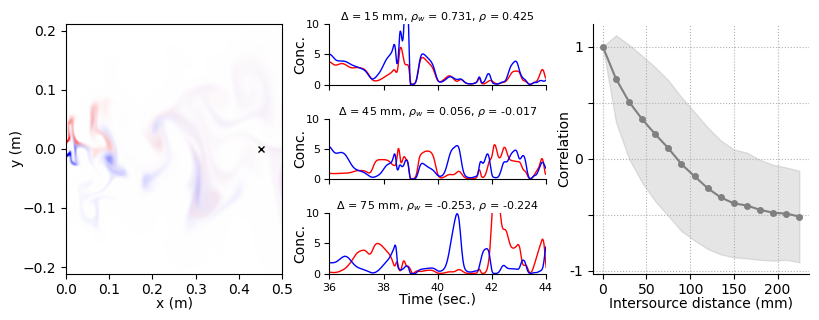

In [118]:
import boulder
reload(fpft)
wnd = Fbw.wnd
name = 'wide'
F = {'wide':Fbw}[name]
figure(figsize=(8,3))
gs = GridSpec(3,3)
ax_plume = subplot(gs[:,0])
pp = boulder.concs2rgb(fields[1,"a",name], fields[1,"b",name])
dx, dy = F.sim0.dimensions
ax_plume.matshow(pp, extent = [0, dx, -dy/2, dy/2])
px, py = F.sim0.get_used_probe_coords()[0]
ax_plume.plot(px, py, "kx", markersize=5)
ax_plume.xaxis.set_ticks_position('bottom')
ax_plume.axis("auto")
xlabel("x (m)", labelpad=-1)
ylabel("y (m)", labelpad=-1)
ax_plume.set_yticks(arange(-0.2,0.21,0.1) if 'wide' in name else arange(-0.1,0.11,0.1))

dists = np.array(sorted(Fbw.sims.keys()))
dists = dists[dists>0]
which_idists = [0,1,2]
tlim = np.array([-4,4]) + t_snapshot
ysc  = 100
yl   = (0,10)
ax_trace = []
for i, di in enumerate(which_idists):
    ax_trace.append(subplot(gs[i,1]))
    a = F.sims[dists[di]].data.flatten()*ysc
    b = F.sims[-dists[di]].data.flatten()*ysc
    t = F.sim0.t
    ax_trace[-1].plot(t,a,color="r", label=f"{dists[di]}", linewidth=1)
    ax_trace[-1].plot(t,b,color="b", label=f"-{dists[di]}", linewidth=1)
    (i < 2) and ax_trace[-1].set_xticklabels([])
    (i ==2) and ax_trace[-1].set_xlabel("Time (sec.)", labelpad=-1)
    fpft.spines_off(ax_trace[-1])
    ax_trace[-1].set_xlim(*tlim)
    #ax_trace[-1].set_xticks(arange(tlim[0],tlim[-1]+1,1))
    ax_trace[-1].set_ylim(*yl)
    ax_trace[-1].set_yticks(arange(0,11,5))
    ax_trace[-1].tick_params(axis='both', labelsize=8)
    ax_trace[-1].set_ylabel("Conc.", labelpad=-1)
    #ax_trace[-1].legend(frameon=False,labelspacing=0,fontsize=6)
    wndf = lambda x: x[(t>=tlim[0])*(t<tlim[-1])]
    aw, bw = wndf(a), wndf(b)
    ρ_w = corrcoef(aw,bw)[0,1]
    ρ   = corrcoef(a, b)[0,1]
    # text(tlim[0], yl[1], f"$\Delta$ = {2*dists[di]/1000:g} mm\n$\\rho$ = {ρ_w:1.3f} (window)\n$\\rho$ = {ρ:1.3f} (all)", fontsize=6, verticalalignment="top")
    title(f"$\Delta$ = {2*dists[di]/1000:g} mm, $\\rho_w$ = {ρ_w:1.3f}, $\\rho$ = {ρ:1.3f}", fontsize=8, verticalalignment="top")
    
    
ax_corr_dist = subplot(gs[:,-1])
rho   = F.rho
dists = np.array(sorted(list(rho.keys()))) 
rho   = {d:rho[d][0] for d in dists} # Take the raw data, not the bootstraps
rhom  = np.array([np.mean(np.sum(rho[d],axis=0)) for d in dists])
rhos  = np.array([ np.std(np.sum(rho[d],axis=0)) for d in dists])
col   = "gray"
plt.fill_between(dists/1000, rhom-rhos,rhom+rhos, color=fpft.set_alpha(mpl.colors.to_rgba(col),0.2));
fpft.pplot(dists/1000, rhom , "o-", markersize=4,color=col);
ax_corr_dist.set_xticks(arange(0,201,50))
ax_corr_dist.grid(True, linestyle=":")
ax_corr_dist.set_yticks(arange(-1,1.1,0.5))
ax_corr_dist.set_yticklabels(["-1","","0","","1"])
ax_corr_dist.set_ylabel("Correlation",labelpad=-1)
ax_corr_dist.set_xlabel("Intersource distance (mm)", labelpad=-1)
tight_layout(pad=0,w_pad=0,h_pad=1)
file_name = f"figs/plumes_demo.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Figure showing the distribution of correlations

Wrote figs/corr_components_bw.pdf.


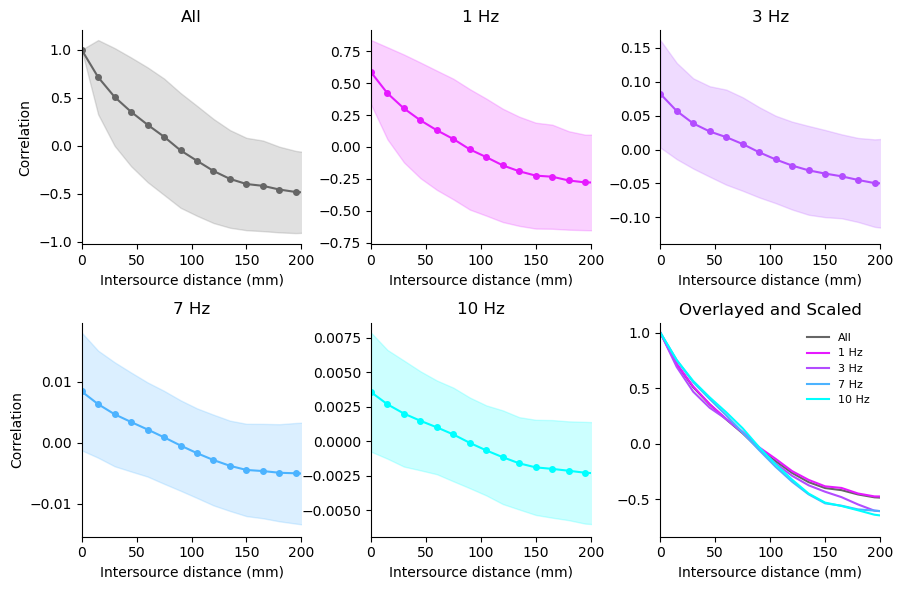

In [119]:
reload(fpf)
which_freqs = [1,3,7,10]
labs = [f"{f} Hz" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f/10) for f in which_freqs])})
slices = {}
for k, F in data.items():
    if k in ["bw"]:
        slices[k] = {"All":slice(1,10000)}
        slices[k].update({l:slice(fi, fi+1) for l, fi in zip(labs, F.freqs2inds(which_freqs))})
        ax = fpf.plot_correlations(F.rho, xl = (0, 120), slices=slices[k], cols=cols, n_rows = 2, plot_order = ["All"] + labs)
        [(axi.set_xlabel("Intersource distance (mm)"), axi.set_xticks(arange(0,201,50))) for axi in ax]
        file_name = f"figs/corr_components_{k}.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

Wrote figs/coef_vs_coef_bw.pdf.


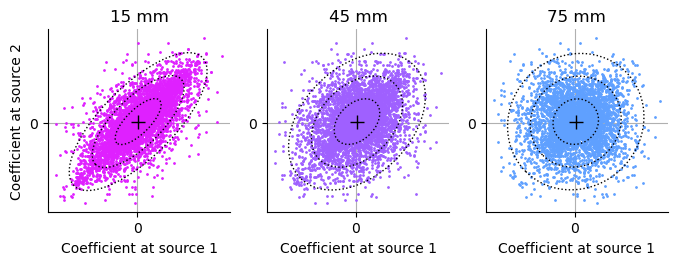

In [120]:
reload(fpf)
which_freq = 5
name = "bw"
F = data[name]
ifreq = F.freqs2inds([which_freq])[0]
fpf.plot_coef1_vs_coef2([F.ss, F.cc],
                        ifreq,
                        F.pairs)
file_name = f"figs/coef_vs_coef_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Asymmetric Laplacian Fits

d=15000 @ Freq #  10: -np.log10(p) = 31.977
d=30000 @ Freq #  10: -np.log10(p) = 18.155
d=45000 @ Freq #  10: -np.log10(p) = 9.682


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:175: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(-np.log10(p), #+np.min(p[p>0])/10),


Wrote figs/alap_fits_bw.pdf.


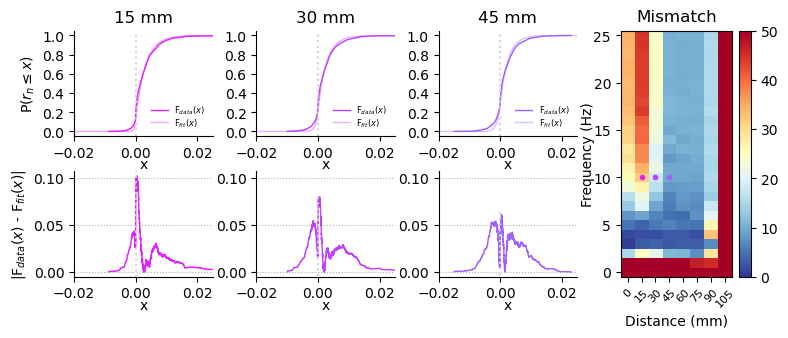

In [121]:
reload(fpf)
d = np.array(list(F.rho.keys()))
d = np.sort(d[d>0])
fpf.plot_alaplace_fits(F, d[:3],
                       ifreq_lim = [],
                       xl = [-0.02,0.025],
                       which_ifreq = 10,
                       figsize=(8,3.5), vmax=50,
                       cm_heat = cm.RdYlBu_r,
                       plot_dvals=True)
file_name = f"figs/alap_fits_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

Wrote figs/la_vs_s_fits_bw.pdf.


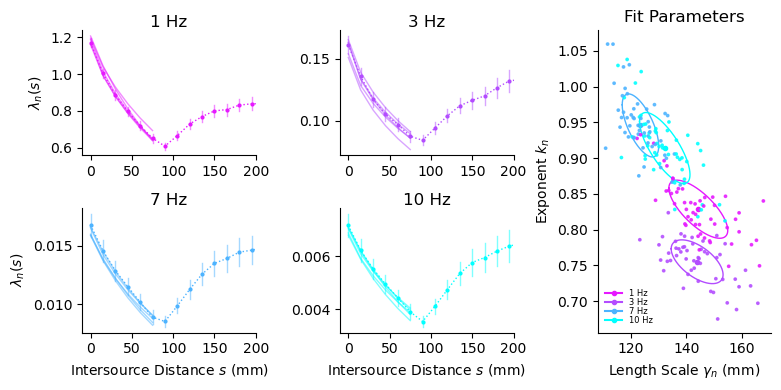

In [142]:
reload(fpft)
reload(fpf)
ax = fpf.plot_la_gen_fits_vs_distance(Fbw, 
                                      xl = (-10,200), figsize=(8,4), legloc = 'right',
                                      which_ifreqs = [1,3,7,10])
[(axi.set_xticks(arange(0,201,50)), (i>1) and axi.set_xlabel("Intersource Distance $s$ (mm)")) for i, axi in enumerate(ax[:4])]
tight_layout(h_pad=1,w_pad=0.5)
file_name = f"figs/la_vs_s_fits_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Fisher information

Wrote figs/fisher_info_bw.pdf.


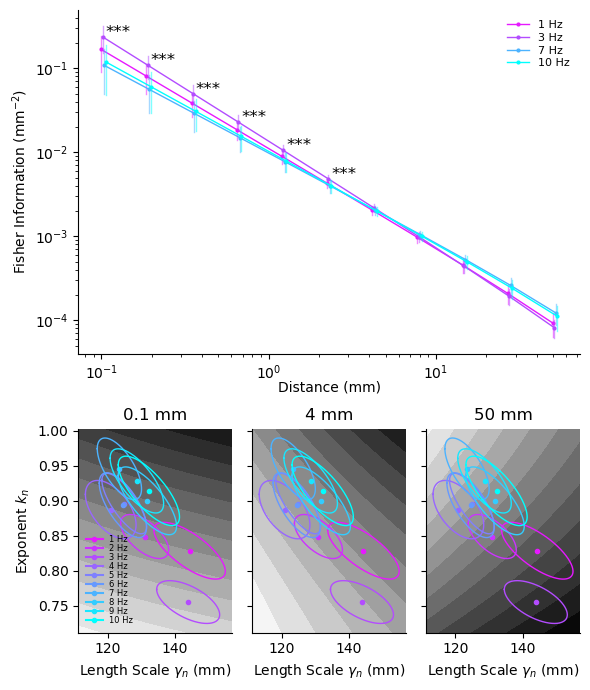

In [148]:
reload(fpf)
figure(figsize=(6,7))
fpf.plot_fisher_information(Fbw,                           
                            d_lim=[1,10000],
                            d_range = [100,50000],
                            d_scale = 1000,
                            d_vals = np.array([0.1,4,50])*1000,
                            d_space_fun = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                            which_ifreqs = [1,3,7,10],
                            x_stagger = lambda x, i: x*(1.02**i),
                            fi_scale = 1, plot_fun = plt.loglog,
)
tight_layout(h_pad=1)
file_name = f"figs/fisher_info_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

In [124]:
! cp figs/*.pdf ../git/crick-fisher/ms/figs

cp: target ‘../git/crick-fisher/ms/figs’ is not a directory


In [128]:
! ls ../

ls: cannot access ../ms: No such file or directory
